In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [2]:
train_dir = '/kaggle/input/fer2013/train'
test_dir = '/kaggle/input/fer2013/test'

In [3]:
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        validation_split = 0.2,    
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [4]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    class_mode='categorical',
    batch_size=64
)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [5]:
base_model = tf.keras.applications.ResNet50V2(input_shape=(48,48,3),include_top=False,weights="imagenet")

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [6]:
# Freezing Layers

In [7]:
# Building Model

model = Sequential([
    base_model,
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.1),
    Dense(256, activation='relu'),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(7, activation='softmax')
])

In [8]:
# Model Summary

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ ?                      │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 23,519,360 (89.72 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [9]:
#Compliling the model
model.compile(optimizer=Adam(learning_rate=0.0001), 
            loss='categorical_crossentropy', 
            metrics=['accuracy'])

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Define the callbacks
checkpoint_callback = ModelCheckpoint(
    filepath='model_weights.weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

earlystop = EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=4, 
    verbose=1, 
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=3, 
    verbose=1, 
    min_delta=0.0001
)


# Train the model
history = model.fit(
    train_generator,
    epochs=35,
    validation_data=val_generator,
    callbacks=[checkpoint_callback, earlystop, reduce_lr]  # Add all callbacks here
)


Epoch 1/35


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731085781.426897      85 service.cc:145] XLA service 0x7f85e0002a50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731085781.426951      85 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/359 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.0820 - loss: 2.0711   

I0000 00:00:1731085807.664319      85 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.2217 - loss: 1.8682
Epoch 1: val_accuracy improved from -inf to 0.28636, saving model to model_weights.weights.h5
359/359 ━━━━━━━━━━━━━━━━━━━━ 222s 463ms/step - accuracy: 0.2218 - loss: 1.8679 - val_accuracy: 0.2864 - val_loss: 1.7580 - learning_rate: 1.0000e-04
Epoch 2/35
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.3233 - loss: 1.6863
Epoch 2: val_accuracy improved from 0.28636 to 0.38565, saving model to model_weights.weights.h5
359/359 ━━━━━━━━━━━━━━━━━━━━ 49s 135ms/step - accuracy: 0.3234 - loss: 1.6861 - val_accuracy: 0.3856 - val_loss: 1.5976 - learning_rate: 1.0000e-04
Epoch 3/35
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.3828 - loss: 1.5665
Epoch 3: val_accuracy improved from 0.38565 to 0.40568, saving model to model_weights.weights.h5
359/359 ━━━━━━━━━━━━━━━━━━━━ 51s 139ms/step - accuracy: 0.3829 - loss: 1.5663 - val_accuracy: 0.4057 - val_loss: 1.5311 - learning_rate: 1.0000e-04
Epoch 4/35
358

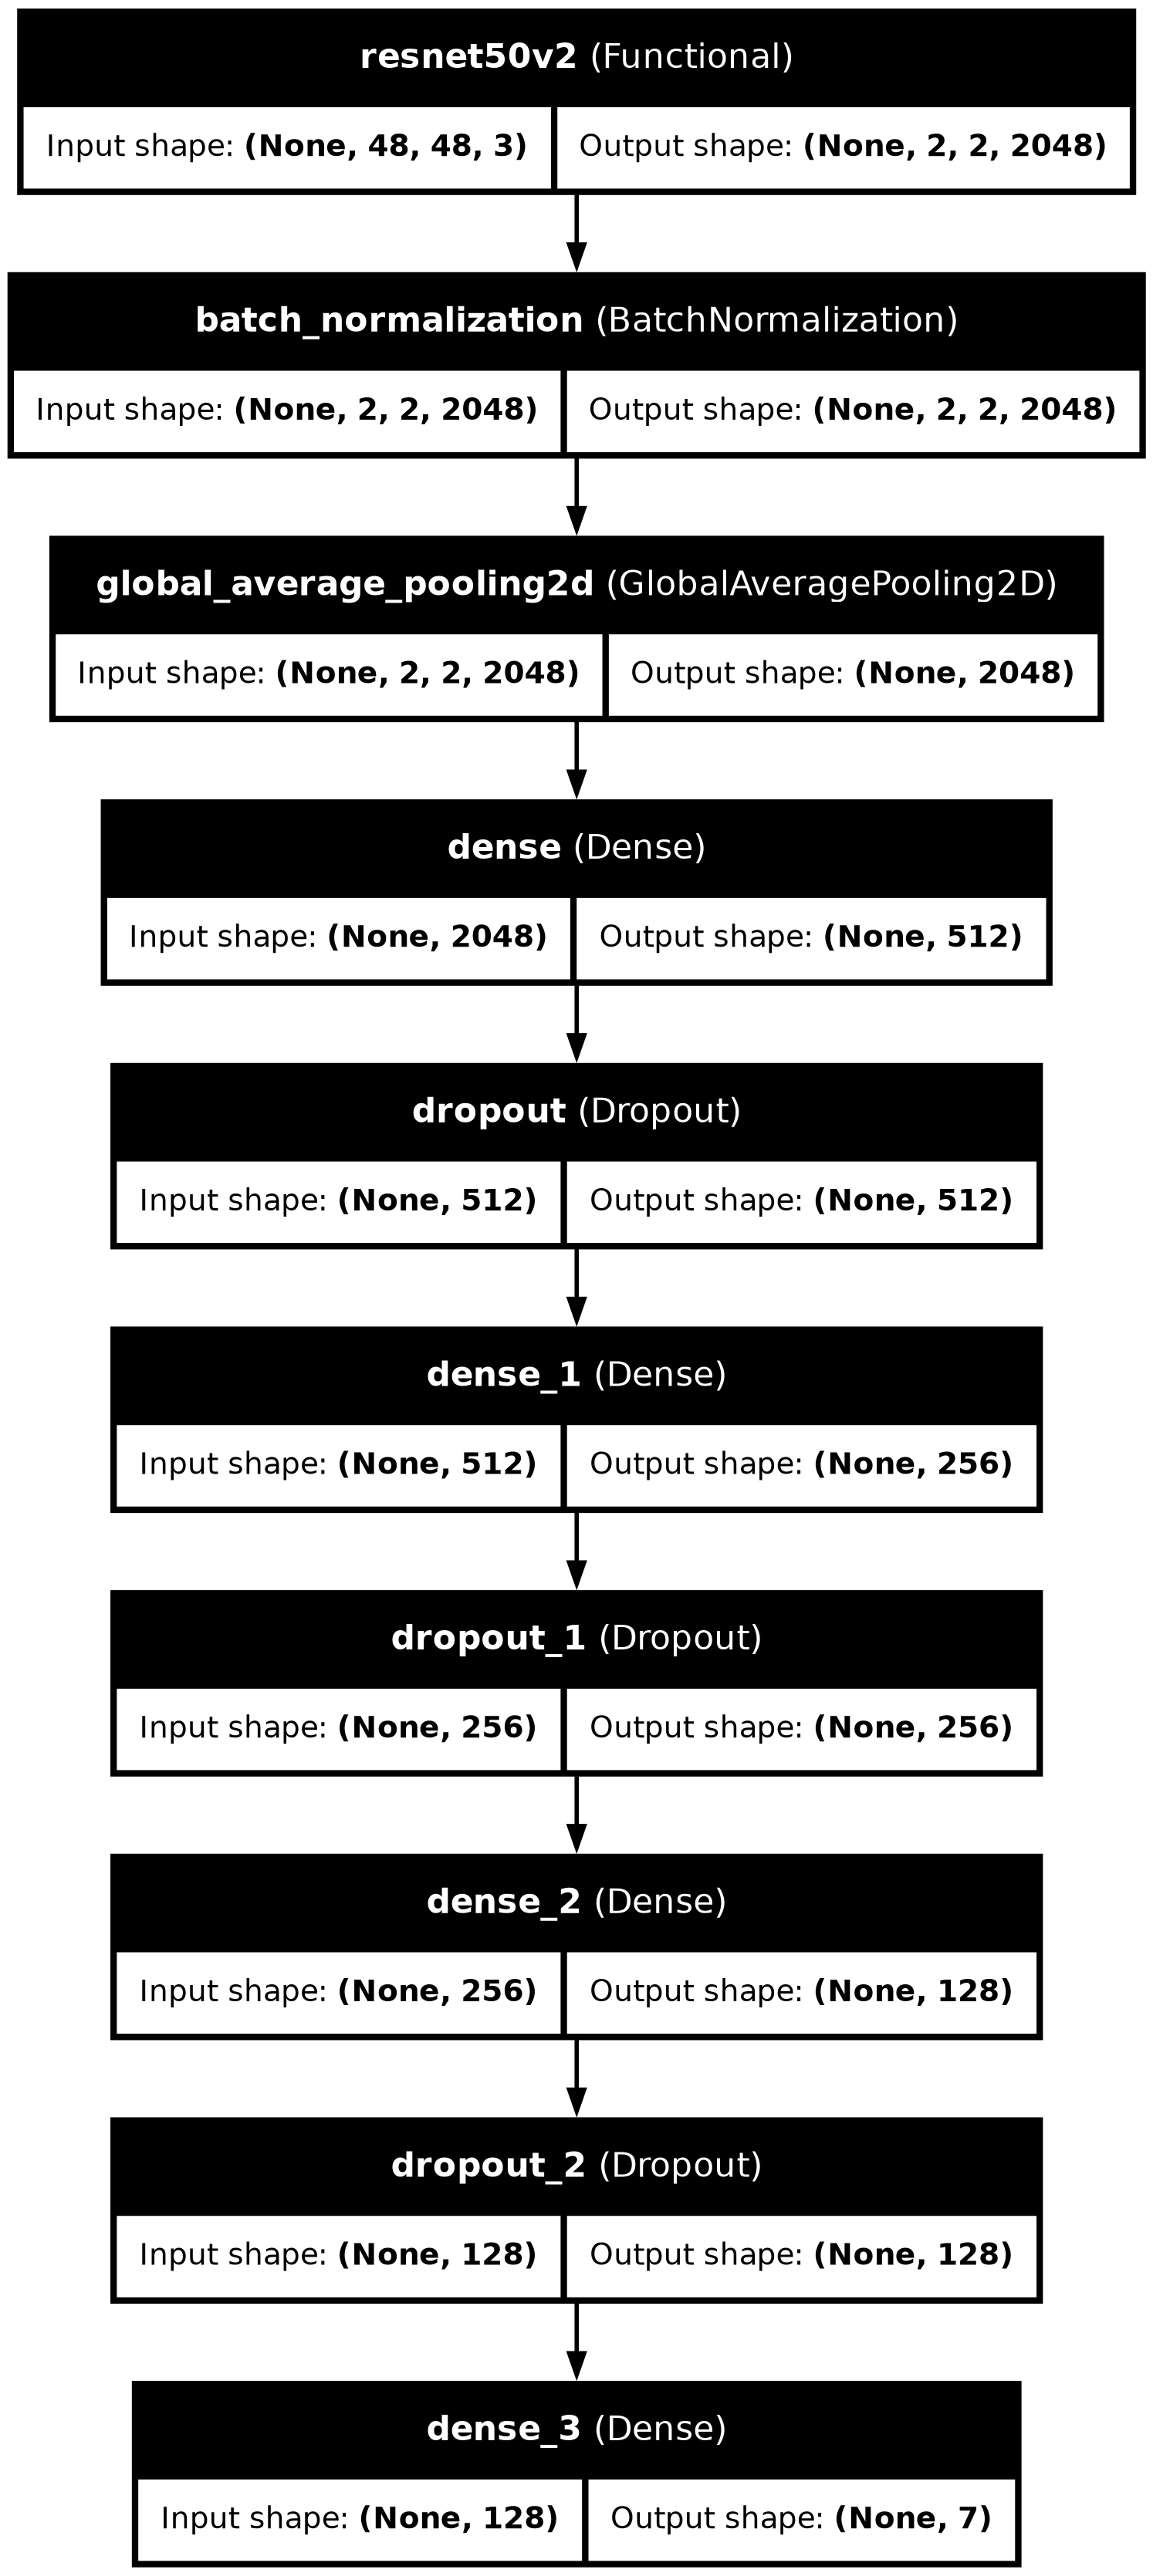

In [11]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 

In [12]:
# Modell kiértékelése a teszt adatokon
model.load_weights(filepath='/kaggle/working/model_weights.weights.h5')
evaluation = model.evaluate(test_generator, verbose=1)
print('Test Loss:', evaluation[0])
print('Test Accuracy:', evaluation[1])

  2/113 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.6484 - loss: 0.9389 

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 32s 281ms/step - accuracy: 0.6176 - loss: 1.0468
Test Loss: 1.05497145652771
Test Accuracy: 0.6153524518013


In [13]:
model.save('model.h5')

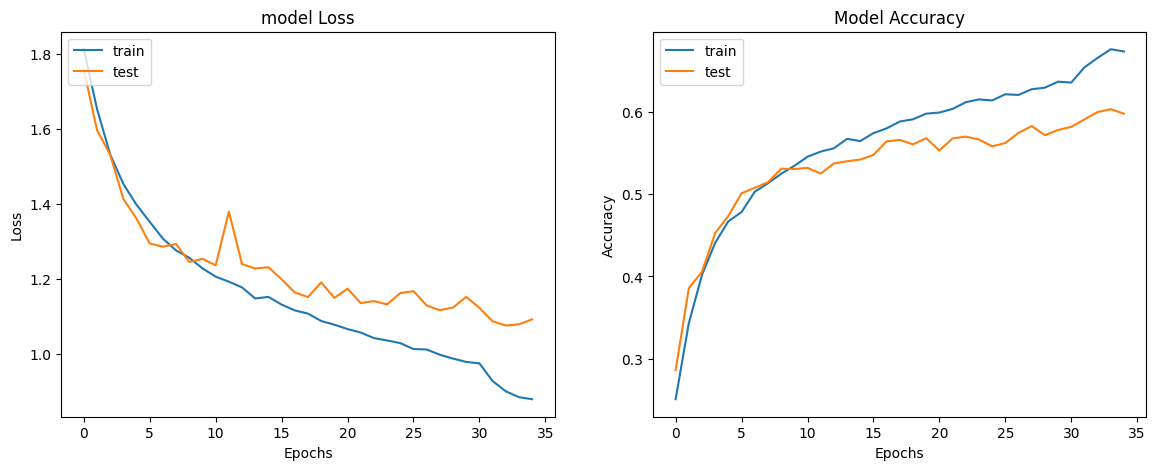

In [14]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

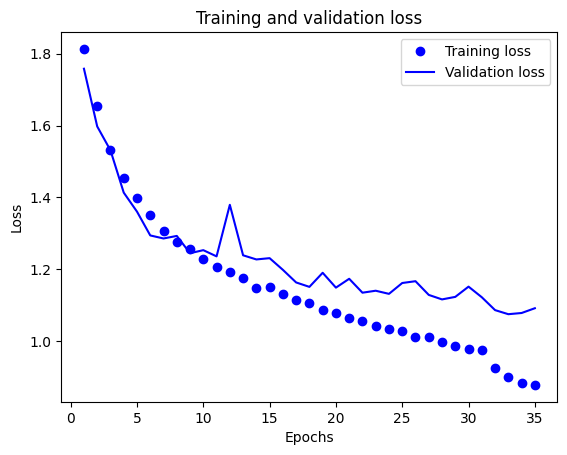

In [15]:
# Plot the train and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

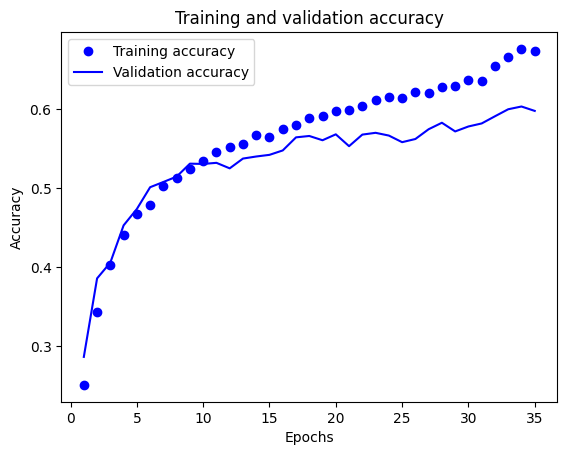

In [16]:
# Plot the train and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step


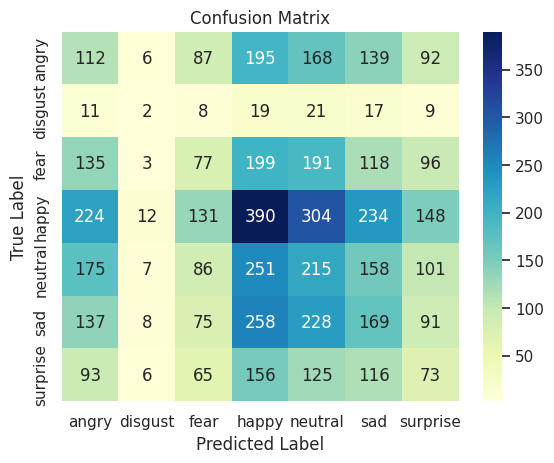

In [17]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix

# Get the true labels and predicted labels for the validation set
validation_labels = val_generator.classes
validation_pred_probs = model.predict(val_generator)
validation_pred_labels = np.argmax(validation_pred_probs, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(validation_labels, validation_pred_labels)
class_names = list(train_generator.class_indices.keys())
sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()